In [65]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from datetime import datetime
from loguru import logger
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.nonparametric.smoothers_lowess import lowess
import re

In [66]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-235500.parquet',
 'inputpath': 'your-path-here.csv',
 'datetime_format': '%d/%m/%Y, %H:%M:%S',
 'drop_authors': [],
 'logging': {'logdir': 'logs'}}

In [67]:
# Remove default logger and add console sink
logger.remove()
logger.add(sys.stderr, level="INFO")

# Get log directory from config
log_dir = Path(config["logging"]["logdir"]).resolve()
log_dir.mkdir(parents=True, exist_ok=True)  # ensure folder exists

# Build timestamped logfile path
# timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logfile = log_dir / f"logfile-{timestamp}.log"

logfile = log_dir / f"logfile.log"

# Add file sink
logger.add(
    logfile,
    rotation="10 MB",
    retention="30 days",
    compression="zip",
    level="DEBUG",
    enqueue=True
)

10

In [68]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

In [69]:
df = pd.read_parquet(datafile)
df.columns

Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length'],
      dtype='object')

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_26210/2987795296.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  camera_length_per_month = df_camera.groupby(df_camera['timestamp'].dt.to_period('M'))['message'].apply(lambda x: x.str.len().sum())


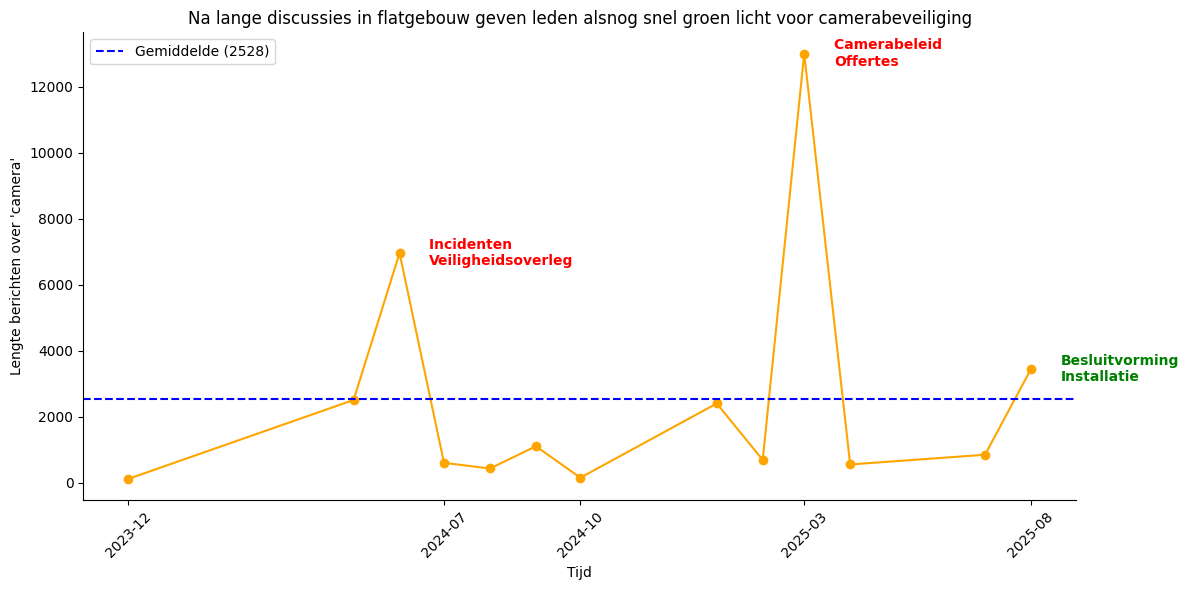

In [70]:
# Create a boolean column: does the message contain 'camera'?
df['has_camera'] = df['message'].str.contains(r'\bcamera\b', flags=re.IGNORECASE, regex=True, na=False)

# Filter messages containing 'camera'
df_camera = df[df['has_camera']]

# Aggregate by month: total length of messages
camera_length_per_month = df_camera.groupby(df_camera['timestamp'].dt.to_period('M'))['message'].apply(lambda x: x.str.len().sum())

# Convert PeriodIndex to datetime for plotting
camera_length_per_month.index = camera_length_per_month.index.to_timestamp()

# --- Find peaks ---
# Peak 1: first value > 6000
peak1 = camera_length_per_month[camera_length_per_month > 6000].idxmin()
peak1_val = camera_length_per_month.loc[peak1]

# Peak 2: first value > 12000
peak2 = camera_length_per_month[camera_length_per_month > 12000].idxmin()
peak2_val = camera_length_per_month.loc[peak2]

# Last dot in the plot (final data point)
last_idx = camera_length_per_month.index[-1]
last_val = camera_length_per_month.iloc[-1]


# --- Plot ---
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(camera_length_per_month.index, camera_length_per_month.values, marker='o', linestyle='-', color='orange')
ax.set_title("Na lange discussies in flatgebouw geven leden alsnog snel groen licht voor camerabeveiliging")
ax.set_xlabel("Tijd")
ax.set_ylabel("Lengte berichten over 'camera'")

# --- Mean line ---
mean_val = camera_length_per_month.mean()
ax.axhline(y=mean_val, color='blue', linestyle='--', linewidth=1.5, label=f"Gemiddelde ({mean_val:.0f})")

# Add legend so the mean line is explained
ax.legend()


# Remove grid
ax.grid(False)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optionally remove left and bottom borders too
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Set x-axis labels every 3 months
ax.set_xticks(camera_length_per_month.index[::3])
ax.set_xticklabels([d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]], rotation=45)

# --- Annotations ---
ax.annotate("Incidenten \nVeiligheidsoverleg",
            xy=(peak1, peak1_val),
            xytext=(peak1 + pd.DateOffset(days=20), peak1_val),
            ha='left', va='center',
            color='red', fontweight='bold')

ax.annotate("Camerabeleid \nOffertes",
            xy=(peak2, peak2_val),
            xytext=(peak2 + pd.DateOffset(days=20), peak2_val),
            ha='left', va='center',
            color='red', fontweight='bold')

ax.annotate("Besluitvorming\nInstallatie",
            xy=(last_idx, last_val),
            xytext=(last_idx + pd.DateOffset(days=20), last_val),
            ha='left', va='center',
            color='green', fontweight='bold')

plt.tight_layout()
plt.show()

